In [1]:
from sigmf_pytorch_dataset import SigMFDataset
from torchsig.utils.visualize import IQVisualizer, SpectrogramVisualizer, two_channel_to_complex
from torchsig.utils.dataset import SignalDataset
from torchsig.datasets.sig53 import Sig53
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from typing import List
from tqdm import tqdm
from datetime import datetime
import numpy as np
import os
from pathlib import Path
from torchsig.models.iq_models.efficientnet.efficientnet import efficientnet_b4
from pytorch_lightning.callbacks import ModelCheckpoint
from torchsig.utils.cm_plotter import plot_confusion_matrix
from pytorch_lightning import LightningModule, Trainer
from sklearn.metrics import classification_report
from torchsig.datasets.sig53 import Sig53
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F
import torchsig.transforms as ST
import numpy as np
import torchsig
import torch
import os
from sigmf_db_dataset import SigMFDB
from sigmf_pytorch_dataset import SigMFDataset
from torchsig.transforms import (
    Compose,
    IQImbalance,
    Normalize,
    RandomApply,
    RandomFrequencyShift,
    RandomPhaseShift,
    RandomResample,
    RandomTimeShift,
    RayleighFadingChannel,
    TargetSNR,
    ComplexTo2D,
)

In [2]:
dataset_path = "./dev_data/torchsig_test/"
num_iq_samples = 4096

In [3]:
# logs_dir = datetime.now().strftime('logs/%H_%M_%S_%m_%d_%Y')
# logs_dir
# logs_dir = Path(logs_dir)
# logs_dir.mkdir(parents=True)

In [4]:
transform = ST.Compose([
    ST.Normalize(norm=np.inf),
    ST.ComplexTo2D(),
])
dataset = SigMFDataset( 
    root=dataset_path, 
    sample_count= num_iq_samples, 
    allowed_filetypes=[".sigmf-data"],
    transform = transform,
)
dataset_class_counts = {class_name:0 for class_name in dataset.class_list}
for data,label in dataset:
    dataset_class_counts[dataset.class_list[label]] += 1
print(f"{len(dataset)=}")
print(dataset_class_counts)

['gamutrf-nz-anon-wifi', 'samples', 'gamutrf-nz-wifi', 'gamutrf-nz-nonanon-wifi', 'fhss_css', '.']
Adding anom_wifi to class list
Adding mini2_telem to class list
Adding mini2_video to class list
Adding wifi6 to class list
Adding wifi to class list
Adding fhss_css to class list
Class List: ['anom_wifi', 'mini2_telem', 'mini2_video', 'wifi6', 'wifi', 'fhss_css']
len(dataset)=121275
{'anom_wifi': 43508, 'mini2_telem': 337, 'mini2_video': 776, 'wifi6': 34685, 'wifi': 41673, 'fhss_css': 296}


In [5]:
# data_loader = DataLoader(
#     dataset=dataset,
#     batch_size=100,
#     shuffle=True,
# )

# visualizer = IQVisualizer(
#     data_loader=data_loader
# )

# for figure in iter(visualizer):
#     figure.set_size_inches(16, 16)
#     plt.show()
#     break

In [6]:
train_data, val_data = torch.utils.data.random_split(dataset, [0.8, 0.2])

sampler = dataset.get_weighted_sampler(indices=train_data.indices)

train_dataloader = DataLoader(
    dataset=train_data, #sig53_clean_train ,
    batch_size=180,
    num_workers=16,
    sampler=sampler,
    # shuffle=True,
    drop_last=True,
)
val_dataloader = DataLoader(
    dataset=val_data, #sig53_clean_train ,
    batch_size=180,
    num_workers=16,
    shuffle=False,
    drop_last=True,
)

In [7]:
train_class_counts = dataset.get_class_counts(indices=train_data.indices)
train_class_counts = {dataset.class_list[k]:v for k,v in train_class_counts.items()}
val_class_counts = dataset.get_class_counts(indices=val_data.indices)
val_class_counts = {dataset.class_list[k]:v for k,v in val_class_counts.items()}
print(f"{len(train_data)=}, {train_class_counts=}")
print(f"{len(val_data)=}, {val_class_counts=}")

len(train_data)=97020, train_class_counts={'anom_wifi': 34760, 'mini2_telem': 269, 'mini2_video': 623, 'wifi6': 27802, 'wifi': 33334, 'fhss_css': 232}
len(val_data)=24255, val_class_counts={'anom_wifi': 8748, 'mini2_telem': 68, 'mini2_video': 153, 'wifi6': 6883, 'wifi': 8339, 'fhss_css': 64}


In [8]:
model = efficientnet_b4(
    pretrained=True,
    path="efficientnet_b4.pt",
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Lightning Model

In [9]:
class ExampleNetwork(LightningModule):
    def __init__(self, model, data_loader, val_data_loader):
        super(ExampleNetwork, self).__init__()
        self.mdl = model
        self.data_loader = data_loader
        self.val_data_loader = val_data_loader

        # Hyperparameters
        self.lr = 0.001
        self.batch_size = data_loader.batch_size

    def forward(self, x):
        return self.mdl(x)

    def predict(self, x):
        with torch.no_grad():
            out = self.forward(x)
        return out

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)

    def train_dataloader(self):
        return self.data_loader

    def training_step(self, batch, batch_nb):
        x, y = batch
        # print(x.shape)
        # print(y.shape)
        y = torch.squeeze(y.to(torch.int64))
        loss = F.cross_entropy(self(x.float()), y)
        return {"loss": loss}

    def val_dataloader(self):
        return self.val_data_loader

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y = torch.squeeze(y.to(torch.int64))
        val_loss = F.cross_entropy(self(x.float()), y)
        self.log("val_loss", val_loss, prog_bar=True)
        return {"val_loss": val_loss}

example_model = ExampleNetwork(model, train_dataloader, val_dataloader)

## Evaluate the Trained Model

In [10]:
# Load best checkpoint
#checkpoint_filename = checkpoint_callback.best_model_path
# checkpoint_filename = "/home/ltindall/rfml-dev/rfml-dev/checkpoints/checkpoint-v9.ckpt"
# checkpoint = torch.load(checkpoint_filename, map_location=lambda storage, loc: storage)
# example_model.load_state_dict(checkpoint["state_dict"], strict=False)
example_model = example_model.eval()
example_model = example_model.cuda() if torch.cuda.is_available() else example_model

In [11]:
# Infer results over validation set
num_test_examples = len(val_data)
# num_classes = 5 #len(list(Sig53._idx_to_name_dict.values()))
# y_raw_preds = np.empty((num_test_examples,num_classes))
y_preds = np.zeros((num_test_examples,))
y_true = np.zeros((num_test_examples,))
y_true_list = []
y_preds_list = []
with torch.no_grad():
    example_model.eval()
    #for i in tqdm(range(0,num_test_examples)):
    for data, label in tqdm(val_dataloader):
        # Retrieve data
        # idx = i # Use index if evaluating over full dataset
        # data, label = val_data[idx]
        # Infer
        data = data.float()
        #data = torch.from_numpy(data).float()
        #data = torch.from_numpy(np.expand_dims(data,0)).float()
        data = data.cuda() if torch.cuda.is_available() else data
        pred_tmp = example_model.predict(data)
        pred_tmp = pred_tmp.cpu().numpy() if torch.cuda.is_available() else pred_tmp


        y_preds_list.extend(np.argmax(pred_tmp, axis=1).tolist())
        y_true_list.extend(label.tolist())
        # # Argmax
        # y_preds[i] = np.argmax(pred_tmp)
        # # Store label
        # y_true[i] = label

100%|███████████████████████████████████████████████████████████| 134/134 [00:34<00:00,  3.89it/s]


In [12]:
y_preds = y_preds_list
y_true = y_true_list

In [13]:
np.unique(np.concatenate((np.arange(len(dataset.class_list)),np.unique(y_preds))))

array([ 0,  1,  2,  3,  4,  5,  6,  9, 10, 14, 15, 18, 19, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 49, 50,
       51, 52])

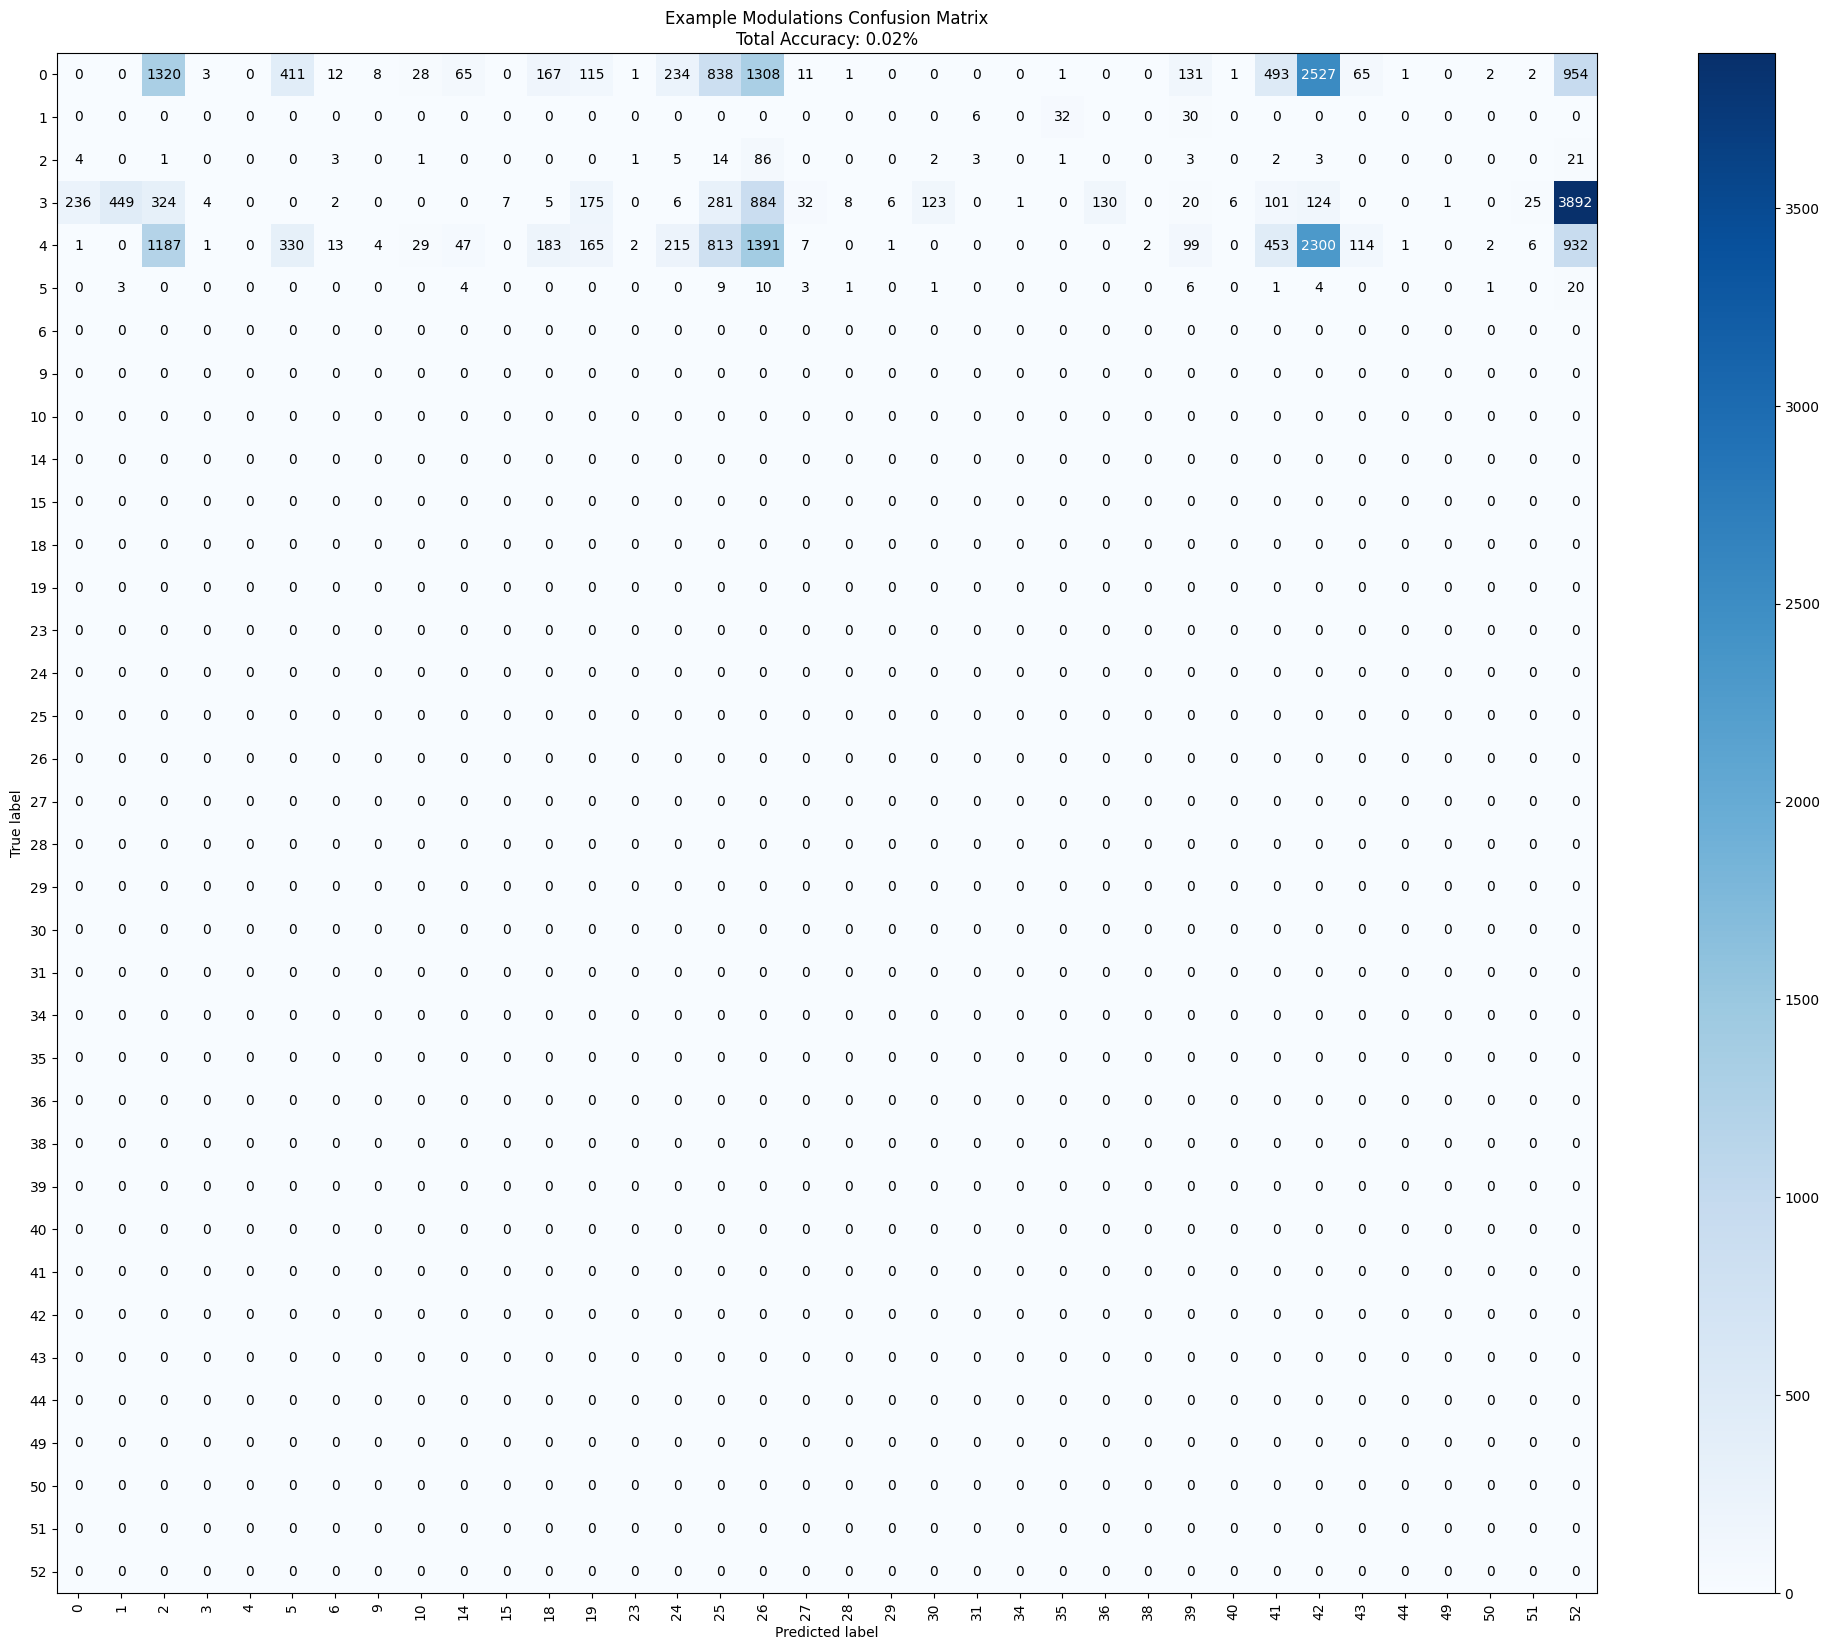

In [14]:
acc = np.sum(np.asarray(y_preds)==np.asarray(y_true))/len(y_true)
plot_confusion_matrix(
    y_true, 
    y_preds, 
    classes=np.unique(np.concatenate((np.arange(len(dataset.class_list)),np.unique(y_preds)))),
    normalize=False,
    title="Example Modulations Confusion Matrix\nTotal Accuracy: {:.2f}%".format(acc*100),
    text=True,
    rotate_x_text=90,
    figsize=(26,20),
)
plt.show()

In [15]:

print(f"{len(train_data)=}, {train_class_counts=}")
print(f"{len(val_data)=}, {val_class_counts=}")

len(train_data)=97020, train_class_counts={'anom_wifi': 34760, 'mini2_telem': 269, 'mini2_video': 623, 'wifi6': 27802, 'wifi': 33334, 'fhss_css': 232}
len(val_data)=24255, val_class_counts={'anom_wifi': 8748, 'mini2_telem': 68, 'mini2_video': 153, 'wifi6': 6883, 'wifi': 8339, 'fhss_css': 64}


In [19]:
for i,c in enumerate(dataset.class_list):
    print(f"{i}, {c}")

0, anom_wifi
1, mini2_telem
2, mini2_video
3, wifi6
4, wifi
5, fhss_css


In [21]:
{i:c for i,c in enumerate(dataset.class_list)}

{0: 'anom_wifi',
 1: 'mini2_telem',
 2: 'mini2_video',
 3: 'wifi6',
 4: 'wifi',
 5: 'fhss_css'}

In [17]:
for i,c in enumerate(torchsig.datasets.modulations.ModulationsDataset().default_classes):
    print(f"{i}, {c}")

0, ook
1, bpsk
2, 4pam
3, 4ask
4, qpsk
5, 8pam
6, 8ask
7, 8psk
8, 16qam
9, 16pam
10, 16ask
11, 16psk
12, 32qam
13, 32qam_cross
14, 32pam
15, 32ask
16, 32psk
17, 64qam
18, 64pam
19, 64ask
20, 64psk
21, 128qam_cross
22, 256qam
23, 512qam_cross
24, 1024qam
25, 2fsk
26, 2gfsk
27, 2msk
28, 2gmsk
29, 4fsk
30, 4gfsk
31, 4msk
32, 4gmsk
33, 8fsk
34, 8gfsk
35, 8msk
36, 8gmsk
37, 16fsk
38, 16gfsk
39, 16msk
40, 16gmsk
41, ofdm-64
42, ofdm-72
43, ofdm-128
44, ofdm-180
45, ofdm-256
46, ofdm-300
47, ofdm-512
48, ofdm-600
49, ofdm-900
50, ofdm-1024
51, ofdm-1200
52, ofdm-2048


In [22]:
model(x)

NameError: name 'x' is not defined

In [23]:
model

EfficientNet(
  (conv_stem): Conv1d(2, 48, kernel_size=(3,), stride=(2,), padding=(1,))
  (bn1): GBN(
    (bn): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv1d(48, 48, kernel_size=(3,), stride=(1,), padding=(1,), groups=48)
        (bn1): GBN(
          (bn): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv1d(48, 12, kernel_size=(1,), stride=(1,))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv1d(12, 48, kernel_size=(1,), stride=(1,))
        )
        (conv_pw): Conv1d(48, 24, kernel_size=(1,), stride=(1,))
        (bn2): GBN(
          (bn): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (act2): Identity()
      )
